In [1]:
%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery
import datetime
import pandas as pd

In [3]:
client = bigquery.Client()

In [4]:
limits = 'LIMIT 15000'
limits=''
sql_events = f"""
WITH geovisits_h3_indexes AS (
    SELECT *, `carto-os-eu`.h3.LONGLAT_ASH3(longitude, latitude, 10) h3_idx
    FROM `ggo-ppos-bqgis.singlespot.geovisits_paris_matview`
)
select sptId, uuid, latitude, longitude, accuracy, eventId,  
arrival, departure, score, rank, category, feature, placeName, h3_idx 
FROM geovisits_h3_indexes {limits}
"""

In [5]:
rows = client.query(sql_events).result()
df = rows.to_dataframe()
df.head()

,sptId,uuid,latitude,longitude,accuracy,eventId,arrival,departure,score,rank,category,feature,placeName,h3_idx
0,548C9692-568A-4144-A6AE-FB7A4EDCAED9,155A9957-B5E6-4117-8EC5-FBBD226A6A69,48.858746,2.275888,20.0,55c85e1f4041235b1583af37b88407cd354bc8dbad4bbe...,2021-07-15 16:37:42 +0200,2021-07-15 17:08:38 +0200,0.722582,1,shop,electronics,Darty,8a1fb4629a8ffff
1,bbe21d71-5be0-4f32-893d-cf1cf29bbbd4,9c49534c-7de0-4a9d-8f68-d2346fd6f7ff,48.825304,2.367324,63.0,8bf0f0909a30467342ec33d2c9791bfee06452c13c4cf3...,2021-07-12 08:51:36 +0200,2021-07-12 09:51:55 +0200,0.589651,1,office,advertising_agency,Vincent AV media,8a1fb4646147fff
2,629b88ed-276f-454c-82f1-613da2ddd824,7b5fa9e9-8e00-477a-940d-4d20e5e585d8,48.855949,2.402709,39.0,0ffe112c037e27dda13a7e6adcff7fc777f24af6d42d7d...,2021-07-12 07:47:23 +0200,2021-07-12 09:50:21 +0200,0.945256,1,shop,beauty,Ô jardin des sens,8a1fb46632d7fff
3,cabbf77e-f839-4dd5-a3b2-24d88be57702,cb7b4514-10f5-4a95-987d-9bb897558056,48.884524,2.338310,48.0,d78ef5d2b4edf534c13234391377907ba5d2039305379d...,2021-07-16 18:35:34 +0200,2021-07-16 20:57:25 +0200,0.797858,1,tourism,artwork,Fontaine Wallace,8a1fb46668e7fff
4,8FB7FCCE-6A30-4ECF-83FA-269A7AC635D0,E0436E44-D2D0-4A3D-9557-8FD12661D47C,48.870971,2.360879,31.0,ce5e700d325e2e4410736036bec409280e552369e7fd23...,2021-07-14 14:26:53 +0200,2021-07-14 14:31:28 +0200,0.549895,1,shop,e-cigarette,Vapor light,8a1fb4660487fff


In [6]:
df['sptId'] = df['sptId'].astype(str)
df['category'] = df['category'].astype(str)
df['feature'] = df['feature'].astype(str)
df['arrival'] = pd.to_datetime(df['arrival'], format='%Y-%m-%d %H:%M:%S', utc=True)
df['depature'] = pd.to_datetime(df['departure'], format='%Y-%m-%d %H:%M:%S', utc=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481634 entries, 0 to 481633
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   sptId      481634 non-null  object             
 1   uuid       481634 non-null  object             
 2   latitude   481634 non-null  float64            
 3   longitude  481634 non-null  float64            
 4   accuracy   481634 non-null  float64            
 5   eventId    481634 non-null  object             
 6   arrival    481634 non-null  datetime64[ns, UTC]
 7   departure  481634 non-null  object             
 8   score      481634 non-null  float64            
 9   rank       481634 non-null  int64              
 10  category   481634 non-null  object             
 11  feature    481634 non-null  object             
 12  placeName  325184 non-null  object             
 13  h3_idx     481634 non-null  object             
 14  depature   481634 non-null  datetime

In [7]:
""" 
h3_g = (df
                          .groupby('h3_idx')
                          .eventId
                          .agg(list)
                          .to_frame("ids")
                          .reset_index())
# Let's count each points inside the hexagon
h3_g['count'] =(h3_g['ids']
                      .apply(lambda ignition_ids:len(ignition_ids))) 
"""

h3_g = df.groupby('h3_idx').h3_idx.agg('count').to_frame('count').reset_index()

In [8]:
h3_g.head()

,h3_idx,count
0,8a1fb460d827fff,10
1,8a1fb460d82ffff,8
2,8a1fb460d907fff,2
3,8a1fb460d90ffff,4
4,8a1fb460d927fff,6


In [9]:
df_w = pd.DataFrame(df[['h3_idx', 'category']])
df_w['count'] = 1
df_w.head()


,h3_idx,category,count
0,8a1fb4629a8ffff,shop,1
1,8a1fb4646147fff,office,1
2,8a1fb46632d7fff,shop,1
3,8a1fb46668e7fff,tourism,1
4,8a1fb4660487fff,shop,1


In [10]:
h3_pivot = pd.DataFrame(pd.pivot_table(df_w,  columns='category', index='h3_idx', values="count", aggfunc=[len], fill_value=0, margins = True, margins_name='total')).reset_index()
h3_pivot.columns = h3_pivot.columns.map('_'.join).str.replace('len_', '')
h3_pivot = h3_pivot.rename(
    columns={'h3_idx_': 'h3_idx'})
h3_pivot.head()

,h3_idx,aeroway,amenity,building,club,craft,highway,historic,landuse,leisure,man_made,natural,office,railway,shop,tourism,user,total
0,8a1fb460d827fff,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,8,10
1,8a1fb460d82ffff,0,2,0,0,0,0,0,0,0,0,0,0,0,6,0,0,8
2,8a1fb460d907fff,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2
3,8a1fb460d90ffff,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,4
4,8a1fb460d927fff,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,6


In [11]:
# 
indexNames = h3_pivot[h3_pivot['h3_idx'] == 'total'].index
h3_pivot.drop(indexNames, inplace=True)
h3_pivot[h3_pivot['h3_idx'] == 'total']
# h3_pivot.info()


,h3_idx,aeroway,amenity,building,club,craft,highway,historic,landuse,leisure,man_made,natural,office,railway,shop,tourism,user,total


In [12]:
from shapely.geometry import Polygon
from geojson.feature import *
import h3

In [13]:
def create_geometry(row, hex_id_field):
  points = h3.h3_to_geo_boundary(row[hex_id_field], True)
  return Polygon(points)

def hexagons_dataframe_to_geojson(df_hex, hex_id_field, value_field,file_output = None):

    list_features = []

    for i, row in df_hex.iterrows():
        feature = Feature(geometry = create_geometry(row, hex_id_field),
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)

    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)

    else :
      return feat_collection

In [14]:
geojson_obj =hexagons_dataframe_to_geojson(h3_pivot, hex_id_field='h3_idx', value_field='total')

In [15]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [16]:
fig = (px.choropleth_mapbox(
                    h3_g, 
                    geojson=geojson_obj, 
                    locations='h3_idx', 
                    color='count',
                    color_continuous_scale="Viridis",
                    range_color=(0,h3_g['count'].mean()),                  
                    mapbox_style='carto-positron',
                    zoom=12,
                    center = {"lat": 48.85432452980058, "lon": 2.3459243774414062},
                    opacity=0.7,
                    labels={'count':'# of visits '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
df_names = h3_pivot.columns
df_names = df_names[1:]
df_names

Index(['aeroway', 'amenity', 'building', 'club', 'craft', 'highway',
       'historic', 'landuse', 'leisure', 'man_made', 'natural', 'office',
       'railway', 'shop', 'tourism', 'user', 'total'],
      dtype='object')

```python
""" 
h3_pivot_corr=h3_pivot[df_names]
correlations= h3_pivot_corr.corr()
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(correlations,vmin=-1,vmax=1)
fig.colorbar(cax)
ticks=np.arange(0,len(df_names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df_names)
ax.set_yticklabels(df_names)
plt.show() """
```

<AxesSubplot:>

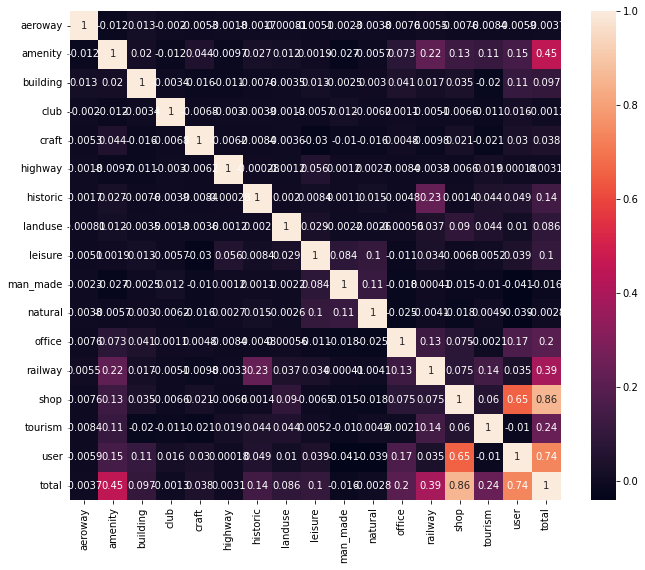

In [19]:
import seaborn as sns
h3_pivot_corr=h3_pivot[df_names]
correlations= h3_pivot_corr.corr()
mask = np.zeros_like(correlations)  # make mask
mask[np.triu_indices_from(mask)] = True  # mask the upper triangle
fig, ax = plt.subplots(figsize=(11, 9))  # create a figure and a subplot
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # custom color map
"""
sns.heatmap(
    correlations,
    mask=mask,
    cmap=cmap,
    center=0,
    linewidth=0.5,
    cbar_kws={'shrink': 0.5}
)
"""
sns.heatmap(
    correlations,
    annot=True
)

In [20]:
correlations

,aeroway,amenity,building,club,craft,highway,historic,landuse,leisure,man_made,natural,office,railway,shop,tourism,user,total
aeroway,1.000000,-0.011595,0.013289,-0.001973,-0.005274,-0.001816,-0.001736,-0.000815,-0.005133,-0.002268,-0.003823,-0.007596,0.005513,-0.007573,-0.008406,-0.005899,-0.003660
amenity,-0.011595,1.000000,0.019622,-0.012220,0.044390,-0.009687,0.027285,0.012038,0.001867,-0.026832,-0.005719,0.073039,0.217467,0.126460,0.111703,0.149194,0.449360
building,0.013289,0.019622,1.000000,-0.003423,-0.015717,-0.010771,-0.007613,-0.003528,0.012989,-0.002483,0.002985,0.041071,0.016592,0.035489,-0.019714,0.106576,0.097288
club,-0.001973,-0.012220,-0.003423,1.000000,-0.006797,-0.002966,-0.003924,-0.001331,-0.005651,0.012231,-0.006244,0.001053,-0.005096,-0.006575,-0.010833,0.015897,-0.001298
craft,-0.005274,0.044390,-0.015717,-0.006797,1.000000,-0.006153,-0.008382,-0.003556,-0.029834,-0.010365,-0.016487,0.004827,-0.009848,0.021186,-0.020997,0.029776,0.037753
highway,-0.001816,-0.009687,-0.010771,-0.002966,-0.006153,1.000000,-0.000282,-0.001224,0.055693,0.001185,0.002664,-0.008387,-0.003264,-0.006639,0.018664,0.000176,0.003063
historic,-0.001736,0.027285,-0.007613,-0.003924,-0.008382,-0.000282,1.000000,0.002043,0.008405,0.001062,0.014826,-0.004756,0.228931,0.001426,0.043882,0.049029,0.138221
landuse,-0.000815,0.012038,-0.003528,-0.001331,-0.003556,-0.001224,0.002043,1.000000,0.028903,-0.002206,-0.002578,-0.000565,0.037315,0.089635,0.044194,0.010296,0.085968
leisure,-0.005133,0.001867,0.012989,-0.005651,-0.029834,0.055693,0.008405,0.028903,1.000000,0.084145,0.102656,-0.010932,0.033514,-0.006462,0.005233,0.039390,0.103890
man_made,-0.002268,-0.026832,-0.002483,0.012231,-0.010365,0.001185,0.001062,-0.002206,0.084145,1.000000,0.114540,-0.018399,0.000412,-0.015403,-0.010466,-0.041283,-0.015991


In [21]:
import tensorflow as tf

KeyboardInterrupt: 

In [ ]:
X = h3_pivot_corr.drop('total',axis=1)
y = h3_pivot_corr['total']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating a model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [ ]:
model = Sequential()

model.add(Dense(8,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400, callbacks=[early_stop])

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
losses.plot()

# Model evaluation

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
predictions = model.predict(X_test)

In [ ]:
mean_absolute_error(y_test,predictions)

In [ ]:
np.sqrt(mean_squared_error(y_test,predictions))